In [1]:
import numpy as np
import pandas as pd
import os
from hmmlearn.hmm import GaussianHMM
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from hmmlearn.hmm import MultinomialHMM
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
os.chdir('C:\\Users\\grace\\UNSW\\COMP4121\\COMP4121_MajorProject\\Data')

In [3]:
#Load datasets
raw_sales_df = pd.read_csv('raw_sales.csv', parse_dates=['datesold'])
ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])

C:\Users\grace\AppData\Local\Temp\ipykernel_14992\3741783504.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])


In [4]:
#Original data frames preview
print(raw_sales_df.head(5))
print(ma_lga_df.head(5))

    datesold  postcode   price propertyType  bedrooms
0 2007-02-07      2607  525000        house         4
1 2007-02-27      2906  290000        house         3
2 2007-03-07      2905  328000        house         3
3 2007-03-09      2905  380000        house         4
4 2007-03-21      2906  310000        house         3
    saledate      MA   type  bedrooms
0 2007-09-30  441854  house         2
1 2007-12-31  441854  house         2
2 2008-03-31  441854  house         2
3 2008-06-30  441854  house         2
4 2008-09-30  451583  house         2


In [5]:
# Step 1: Add year_quarter column to raw_sales_df and convert datesold to datetime
raw_sales_df['datesold'] = pd.to_datetime(raw_sales_df['datesold'])
raw_sales_df['year_quarter'] = raw_sales_df['datesold'].dt.year.astype(str) + '_Q' + raw_sales_df['datesold'].dt.quarter.astype(str)

# Step 2: Add year_quarter column to ma_lga_df and convert saledate to datetime
ma_lga_df['saledate'] = pd.to_datetime(ma_lga_df['saledate'])
ma_lga_df['year_quarter'] = ma_lga_df['saledate'].dt.year.astype(str) + '_Q' + ma_lga_df['saledate'].dt.quarter.astype(str)

In [6]:
# Step 3: Merge the dataframes on 'year_quarter', 'bedrooms', and 'type'
merged_df = pd.merge(
    raw_sales_df, 
    ma_lga_df[['year_quarter', 'type', 'bedrooms', 'MA']],  # Only the necessary columns from ma_lga_df
    how='left',  # Perform a left join to keep all rows from raw_sales_df
    left_on=['year_quarter', 'propertyType', 'bedrooms'],  # Merging keys
    right_on=['year_quarter', 'type', 'bedrooms']  # Merging keys in ma_lga_df
)

# Step 4: Rename columns to match raw_sales_df column names
merged_df = merged_df.rename(columns={
    'propertyType': 'property_type',  # Rename 'propertyType' to 'property_type'
    'datesold': 'date_sold'          # Rename 'datesold' to 'date_sold         # Fix duplicate column issue after merge
})

# Step 5: Drop 'property_type' column (duplicate after renaming)
merged_df['MA'] = merged_df['MA'].apply(lambda x: '{:.0f}'.format(x))
merged_df = merged_df.drop(columns=['type'])

# Step 6: Drop data entries with bedrooms = 0, since there are only 30 entries
merged_df = merged_df[merged_df['bedrooms'] != 0]

Feature Engineering
- Mutated 'normalized_price'
    - Based on median price in a given year_sold x and bedroom y
        - 'normalized_price_median' = 'price' / 'median_price' 

Background
- Let the median price-based normalized price represent the price relative to the specific bedroom category and year.
- Let the MA-based normalized price represent the long-term market trend.

- A 'normalized_price' close to 1 represents a given property is close to a median or stable market price, greater than 1.2 represents price is 20% higher , etc.




In [7]:
#Step 1: Mutate 'year_sold'
merged_df['year_sold'] = merged_df['date_sold'].dt.year

# Step 2: Group by year and number of bedrooms to calculate median price
median_price_by_bedrooms_year = merged_df.groupby(['year_sold', 'bedrooms'])['price'].median().reset_index()
median_price_by_bedrooms_year.columns = ['year_sold', 'bedrooms', 'median_price']

# Step 3: convert 'median_price' and 'MA' to required float or int types
median_price_by_bedrooms_year['median_price'] = median_price_by_bedrooms_year['median_price'].astype('int64')
merged_df['MA'] = pd.to_numeric(merged_df['MA'], errors='coerce')

# Step 4: Merge 'merged_df' with 'median_price_by_bedrooms_year' on 'year_sold' and 'bedrooms'
merged_df = pd.merge(merged_df, median_price_by_bedrooms_year, on=['year_sold', 'bedrooms'], how='left')


In [8]:
# Step 1: Normalize price using MA and median price (as before)
merged_df['normalized_price'] = merged_df['price'] / merged_df['median_price']


In [9]:
print(merged_df.head(5))

   date_sold  postcode   price property_type  bedrooms year_quarter        MA  \
0 2007-02-07      2607  525000         house         4      2007_Q1  548969.0   
1 2007-02-27      2906  290000         house         3      2007_Q1  421291.0   
2 2007-03-07      2905  328000         house         3      2007_Q1  421291.0   
3 2007-03-09      2905  380000         house         4      2007_Q1  548969.0   
4 2007-03-21      2906  310000         house         3      2007_Q1  421291.0   

   year_sold  median_price  normalized_price  
0       2007        558000          0.940860  
1       2007        425000          0.682353  
2       2007        425000          0.771765  
3       2007        558000          0.681004  
4       2007        425000          0.729412  


In [10]:
merged_df_prescaling = merged_df[['date_sold', 'year_sold', 'price', 'bedrooms', 'year_quarter', 'MA', 'normalized_price']].dropna()

merged_df_prescaling


,date_sold,year_sold,price,bedrooms,year_quarter,MA,normalized_price
0,2007-02-07,2007,525000,4,2007_Q1,548969.0,0.940860
1,2007-02-27,2007,290000,3,2007_Q1,421291.0,0.682353
2,2007-03-07,2007,328000,3,2007_Q1,421291.0,0.771765
3,2007-03-09,2007,380000,4,2007_Q1,548969.0,0.681004
4,2007-03-21,2007,310000,3,2007_Q1,421291.0,0.729412
...,...,...,...,...,...,...,...
29545,2019-07-25,2019,500000,3,2019_Q3,597884.0,0.884956
29546,2019-07-25,2019,560000,2,2019_Q3,424412.0,1.369193
29547,2019-07-26,2019,464950,2,2019_Q3,424412.0,1.136797
29548,2019-07-26,2019,589000,2,2019_Q3,424412.0,1.440098


In [11]:
#Save merged_df_prescaling
merged_df_prescaling.to_csv('merged_df_prescaling.csv', index=False)  # index=False to exclude row numbers
print("DataFrame saved as 'merged_df_prescaling.csv'")

DataFrame saved as 'merged_df_prescaling.csv'


In [12]:
# Convert categorical variable 'propertyType' to numerical if needed
merged_df['year_quarter'] = merged_df['year_quarter'].astype('category').cat.codes  # Encode 'propertyType' as numeric
merged_df['normalized_price'] = merged_df['normalized_price'].astype('category').cat.codes
merged_df['property_type'] = merged_df['property_type'].astype('category').cat.codes

# Scale the features (exclude 'price' because it's the target)
features = merged_df[['MA', 'bedrooms', 'normalized_price']].dropna()
#scaler = MinMaxScaler()
#features_scaled = scaler.fit_transform(features)
features_scaled = features

# Drop columns not relevant to EDA
merged_df = merged_df.drop(columns=['year_sold'])
merged_df = merged_df.drop(columns=['median_price'])

# Now you can proceed to use the 'features' for the HMM modeling


Split data into Test and Train

In [13]:
'''# Step 1: Aggregate price data by time period (e.g., month)
#merged_df['month'] = merged_df['date_sold'].dt.month.astype(str)
#to_period('M')
aggregated_df = merged_df.groupby(['year_quarter'])['price'].mean().reset_index()
aggregated_df['price'] = round(aggregated_df['price'], 2)

# Step 2: Calculate price change percentage
aggregated_df['price_change'] = aggregated_df['price'].pct_change() * 100

# Step 3: Define thresholds and assign labels (Increase, Decrease, Stable)
threshold = 1  # example threshold
aggregated_df['price_movement'] = aggregated_df['price_change'].apply(
    lambda x: 0 if x < -threshold else (1 if abs(x) <= threshold else 2)
)

aggregated_df = aggregated_df[['year_quarter', 'price', 'price_change', 'price_movement']].dropna()



print(aggregated_df.head(20))

len(aggregated_df)'''


"# Step 1: Aggregate price data by time period (e.g., month)\n#merged_df['month'] = merged_df['date_sold'].dt.month.astype(str)\n#to_period('M')\naggregated_df = merged_df.groupby(['year_quarter'])['price'].mean().reset_index()\naggregated_df['price'] = round(aggregated_df['price'], 2)\n\n# Step 2: Calculate price change percentage\naggregated_df['price_change'] = aggregated_df['price'].pct_change() * 100\n\n# Step 3: Define thresholds and assign labels (Increase, Decrease, Stable)\nthreshold = 1  # example threshold\naggregated_df['price_movement'] = aggregated_df['price_change'].apply(\n    lambda x: 0 if x < -threshold else (1 if abs(x) <= threshold else 2)\n)\n\naggregated_df = aggregated_df[['year_quarter', 'price', 'price_change', 'price_movement']].dropna()\n\n\n\nprint(aggregated_df.head(20))\n\nlen(aggregated_df)"

In [14]:
import pandas as pd

# Ensure 'date_sold' is in datetime format
#merged_df['date_sold'] = pd.to_datetime(merged_df['date_sold'])

# Create 'year_quarter' column based on 'date_sold'
#merged_df['year_quarter'] = merged_df['date_sold'].dt.to_period('Q')

# Sort by 'year_quarter' to calculate price change over time
merged_df = merged_df.sort_values(by=['year_quarter'])

# Calculate price change percentage by quarter
merged_df['price_change'] = round(merged_df.groupby('year_quarter')['price'].pct_change() * 100, 2)  # price_change in %

# Define thresholds for movement classification (increase, stable, decrease)
threshold = 1  # Define a threshold percentage (e.g., 1% increase or decrease)
merged_df['price_movement'] = merged_df['price_change'].apply(
    lambda x: 0 if x < -threshold else (1 if abs(x) <= threshold else 2)
)

# Add a column for year for convenience if needed
merged_df['year'] = merged_df['date_sold'].dt.year

merged_df = merged_df[['MA', 'bedrooms','date_sold', 'price', 'normalized_price', 'year_quarter', 'price_change', 'price_movement']].dropna()


# Merge back into merged_df or keep them for further analysis
merged_df

,MA,bedrooms,date_sold,price,normalized_price,year_quarter,price_change,price_movement
1,421291.0,3,2007-02-27,290000,449,0,-44.76,0
2,421291.0,3,2007-03-07,328000,1227,0,13.10,2
3,548969.0,4,2007-03-09,380000,441,0,15.85,2
4,421291.0,3,2007-03-21,310000,797,0,-18.42,0
13,548969.0,4,2007-06-28,765000,9104,1,47.97,2
...,...,...,...,...,...,...,...,...
24414,510712.0,2,2019-07-05,424500,5768,50,-51.11,0
24415,631875.0,3,2019-07-05,460000,1837,50,8.36,2
24416,510712.0,2,2019-07-05,473000,7349,50,2.83,2
24418,791446.0,4,2019-07-05,665000,3772,50,40.59,2


In [15]:
# Define your features (X) and target (y)
X = merged_df[['year_quarter','normalized_price', 'MA', 'bedrooms']]  # Add any other relevant features
y = merged_df['price_movement']

# Split the data into training and test sets (e.g., 80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Step 4: Train HMM on aggregated data

hmm_model = MultinomialHMM(n_components=3)  # 3 states: Decrease, Stable, Increase
X_train = merged_df['price_movement'].values.reshape(-1, 1)  # Reshape for HMM
hmm_model.fit(X_train)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


KeyError: 'price_movement'

Exploratory Data Analysis
- Heat Map of the Correlation Matrix

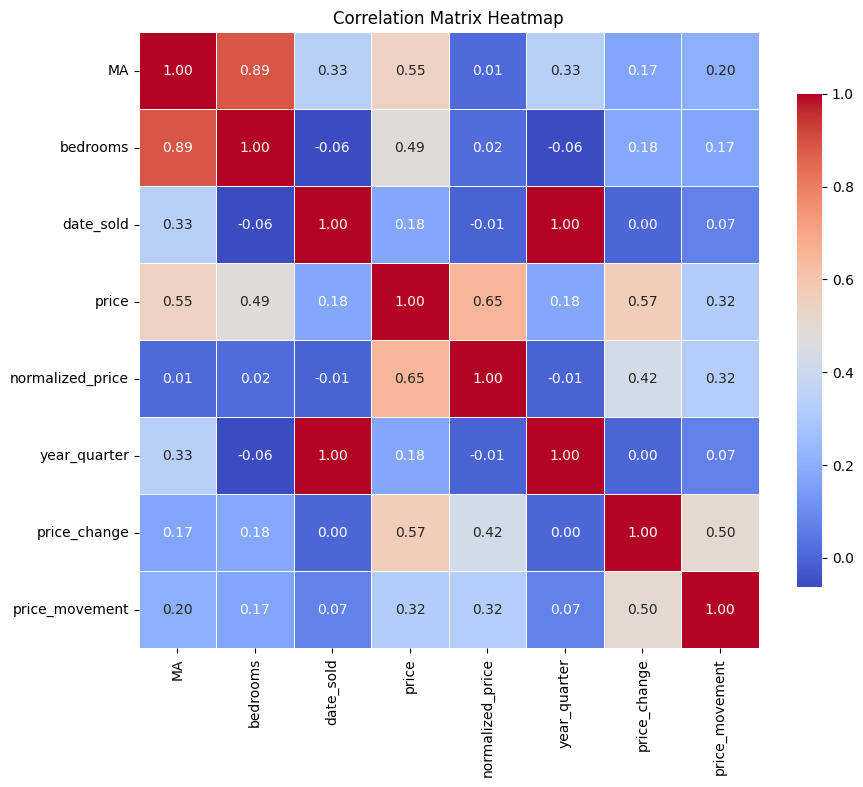

In [17]:

corr_matrix = merged_df.corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create the heatmap with annotations and a color map (e.g., 'coolwarm')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8})

# Add a title
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

In [18]:
def find_optimal_states(features, max_states):
    """
    Find the optimal number of states for HMM based on AIC and BIC.
    
    Args:
    - features (numpy.ndarray): Scaled feature matrix.
    - max_states (int): Maximum number of hidden states to test.

    Returns:
    - optimal_states_aic (int): Optimal number of states based on AIC.
    - optimal_states_bic (int): Optimal number of states based on BIC.
    - aic_scores (list): List of AIC values for each number of states.
    - bic_scores (list): List of BIC values for each number of states.
    """
    aic_scores = []
    bic_scores = []
    models = []
    
    for n_states in range(2, max_states + 1):  # Test models with 2 to max_states
        hmm = GaussianHMM(n_components=n_states, covariance_type="diag", random_state=42, n_iter=100)
        hmm.fit(features)
        models.append(hmm)
        
        # Calculate log likelihood
        log_likelihood = hmm.score(features)
        
        # Number of parameters
        num_params = n_states**2 + 2 * n_states * features.shape[1] - 1
        
        # Calculate AIC and BIC
        aic = 2 * num_params - 2 * log_likelihood
        bic = np.log(len(features)) * num_params - 2 * log_likelihood
        
        aic_scores.append(aic)
        bic_scores.append(bic)
    
    # Find optimal number of states
    optimal_states_aic = 2 + np.argmin(aic_scores)
    optimal_states_bic = 2 + np.argmin(bic_scores)
    
    return optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models

# Call the function and get AIC/BIC values
optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models = find_optimal_states(features=features_scaled, max_states=5)

print(f"Optimal number of states based on AIC: {optimal_states_aic}")
print(f"Optimal number of states based on BIC: {optimal_states_bic}")


Optimal number of states based on AIC: 5
Optimal number of states based on BIC: 5


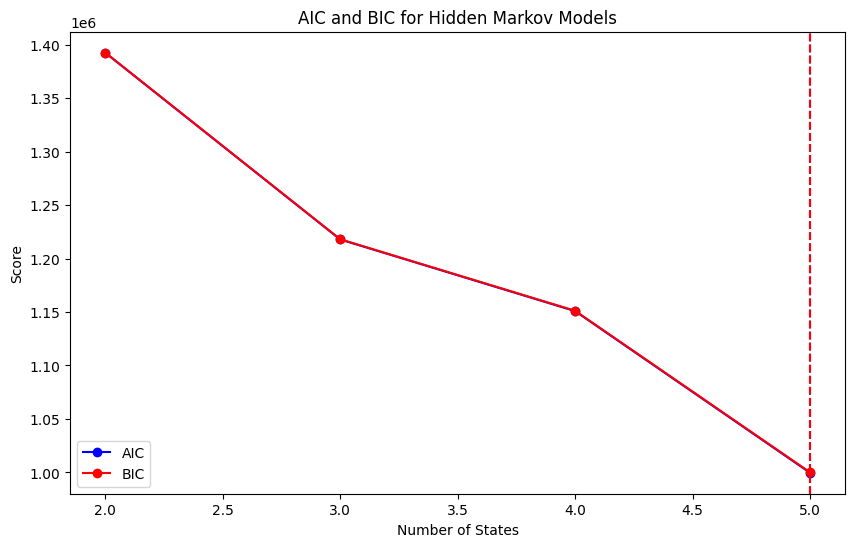

In [19]:
# Plot AIC and BIC
states_range = range(2, len(aic_scores) + 2)

plt.figure(figsize=(10, 6))
plt.plot(states_range, aic_scores, marker='o', label='AIC', color='blue')
plt.plot(states_range, bic_scores, marker='o', label='BIC', color='red')
plt.axvline(optimal_states_aic, color='blue', linestyle='--')
plt.axvline(optimal_states_bic, color='red', linestyle='--')
#plt.axvline(optimal_states_aic, color='blue', linestyle='--', label=f'Optimal States (AIC): {optimal_states_aic}')
#plt.axvline(optimal_states_bic, color='red', linestyle='--', label=f'Optimal States (BIC): {optimal_states_bic}')
plt.xlabel('Number of States')
plt.ylabel('Score')
plt.title('AIC and BIC for Hidden Markov Models')
plt.legend()
#plt.show()


Decided on 5 hidden states rather than 9, to avoid overfitting (considering the elbow method).

In [20]:
len(features_scaled)
len(features)

na_counts = merged_df.isna().sum()
print(na_counts)

merged_df = merged_df[['date_sold', 'price', 'bedrooms', 'year_quarter', 'MA', 'normalized_price']].dropna()
len(merged_df)

merged_df.head()

MA                  0
bedrooms            0
date_sold           0
price               0
normalized_price    0
year_quarter        0
price_change        0
price_movement      0
dtype: int64


,date_sold,price,bedrooms,year_quarter,MA,normalized_price
1,2007-02-27,290000,3,0,421291.0,449
2,2007-03-07,328000,3,0,421291.0,1227
3,2007-03-09,380000,4,0,548969.0,441
4,2007-03-21,310000,3,0,421291.0,797
13,2007-06-28,765000,4,1,548969.0,9104


In [21]:
# Use the model with the optimal number of states based on BIC or AIC

# Predict the hidden states (regimes) for each observation
best_model = models[optimal_states_aic - 2]  # Adjust for 0-indexing in the models list
hidden_states = best_model.predict(features_scaled)

# Add hidden states to the dataframe
merged_df['hidden_state'] = hidden_states

# Plot the regimes over time
plt.figure(figsize=(12, 6))
for state in range(best_model.n_components):
    state_data = merged_df[merged_df['hidden_state'] == state]
    plt.scatter(state_data['date_sold'], state_data['price'], label=f'State {state}', s=6)

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.legend()
plt.title('Price Segmented by State (AIC)')
plt.xlabel('Date Sold')
plt.ylabel('Price')
#plt.show()


ValueError: Length of values (29414) does not match length of index (29363)

In [ ]:
#Prepare data
# Define the features (predictors) and target variable (hidden_state)
features = ['MA', 'bedrooms']
target = 'hidden_state'

# Prepare your X (features) and y (target)
X = merged_df[features]
y = merged_df[target]

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preview the result
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


1. Fit HMM to Observed Data

In [ ]:
# Train HMM with the optimal number of states
n_states = 5
hmm_model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100, random_state=42)
hmm_model.fit(features_scaled)

# Get the transition matrix
transition_matrix = hmm_model.transmat_

# Print the transition matrix
print("Transition Matrix:")
print(transition_matrix)

sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Transition Matrix Heatmap")
plt.xlabel("To State")
plt.ylabel("From State")
plt.show()

GaussianHMM(n_components=5, n_iter=100, random_state=42)

2. Analyze Hidden States

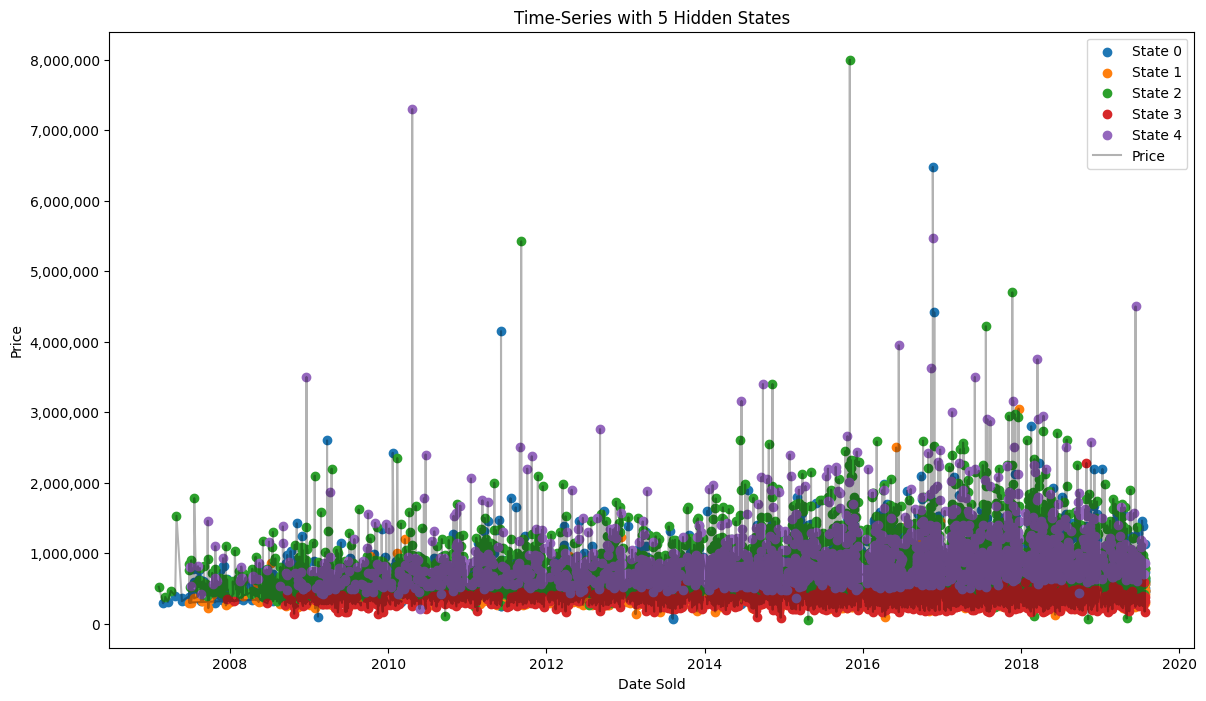

In [ ]:
plt.figure(figsize=(14, 8))

for state in range(n_states):
    # Select rows belonging to the current state
    state_indices = merged_df[merged_df['hidden_state'] == state].index
    plt.scatter(merged_df.loc[state_indices, 'date_sold'], 
                merged_df.loc[state_indices, 'price'] * 1, 
                label=f"State {state}")

plt.plot(merged_df['date_sold'], merged_df['price'] * 1, color="black", alpha=0.3, label="Price")

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.legend()
plt.title("Time-Series with 5 Hidden States")
plt.xlabel("Date Sold")
plt.ylabel("Price")
plt.show()

3. Average Price and Variance for each Hidden State

In [ ]:
state_stats = merged_df.groupby('hidden_state')['price'].agg(['mean', 'var', 'count'])
state_stats = round(state_stats, 2)
print("State Statistics:")
print(state_stats)

State Statistics:
                   mean           var  count
hidden_state                                
0             552304.43  4.136790e+10  11933
1             442222.92  2.402423e+10   3598
2             718450.31  7.669289e+10  10404
3             335163.84  8.629894e+09   1532
4             918705.86  1.924235e+11   1947


In [ ]:
merged_df.head(5)

,date_sold,price,bedrooms,year_quarter,MA,normalized_price,hidden_state
0,2007-02-07,525000,4,0,548969.0,4078,2
1,2007-02-27,290000,3,0,421291.0,449,0
2,2007-03-07,328000,3,0,421291.0,1227,0
3,2007-03-09,380000,4,0,548969.0,441,2
4,2007-03-21,310000,3,0,421291.0,797,0


In [ ]:
# Save n_states and X
np.savez('hmm_data.npz', n_states=n_states, X=features_scaled)
print("Variables saved to hmm_data.npz")

Variables saved to hmm_data.npz


In [ ]:
#Save merged_df to a csv file
merged_df.to_csv('merged_df.csv', index=False)  # index=False to exclude row numbers
print("DataFrame saved as 'merged_df.csv'")

DataFrame saved as 'merged_df.csv'
